In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
path = '/kaggle/input/dados-saresp/'
df_list = []
for file_name in os.listdir(path):
    file_sep = ';' if file_name != '2021.csv' else ','
    file_df = pd.read_csv(path + file_name, sep=file_sep)
    file_df['ano_prova'] = int(file_name[0:4])
    file_df.rename(columns={"SERIE_ANO": "SERIE", "Turma": "TURMA","porc_ACERT_mat": "porc_ACERT_MAT","validade": "VALIDADE","TP_SEXO": "SEXO"},inplace=True)
    df_list.append(file_df)
df = pd.concat(df_list)

/tmp/ipykernel_32/4087518414.py:5: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  file_df = pd.read_csv(path + file_name, sep=file_sep)
/tmp/ipykernel_32/4087518414.py:5: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  file_df = pd.read_csv(path + file_name, sep=file_sep)
/tmp/ipykernel_32/4087518414.py:5: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  file_df = pd.read_csv(path + file_name, sep=file_sep)
/tmp/ipykernel_32/4087518414.py:5: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  file_df = pd.read_csv(path + file_name, sep=file_sep)


In [3]:
# Formatando valores da coluna de sexo
def set_sexo_value(value):
    if str(value) == '1':
        return 'M'
    if str(value) == '2':
        return 'F'
    return value
df['SEXO'] = df['SEXO'].apply(set_sexo_value)

In [4]:
# Removendo colunas de códigos, turma/classe (não serão realizadas analises nesses campos)
# e nomedep pois ja possui uma coluna que representa o mesmo valor (NomeDepBol)
removed_columns = ['CD_ALUNO','CDREDE','CODMUN','CODESC','TURMA','CLASSE','NOMEDEP']
df.drop(removed_columns,axis=1,inplace=True)

In [5]:
# Formatando o campo particip_cie para booleano não nulo
df['particip_cie'] = df['particip_cie'].apply(lambda x : 1 if x == 1.0 else 0)

In [6]:
# Formatando as colunas de proficiência e acertos
def parse_string_fields_to_float(fields):
    for field in fields:
        df[field] = df[field].apply(lambda x : str(x).replace(',','.')).astype(float)
parse_string_fields_to_float(['profic_mat','profic_lp','profic_cie','porc_ACERT_lp','porc_ACERT_MAT','porc_ACERT_CIE'])

In [7]:
# Formatando coluna de periodo
df['PERIODO'] = df['PERIODO'].apply(lambda x : 'MANHÃ' if x == 'MANHA' else x)

In [9]:
df.drop(['cad_prova_mat','cad_prova_lp','cad_prova_cie'],axis=1,inplace=True)

In [10]:
df = df[df['Tem_Nec'] == 0].drop(['NEC_ESP_1','NEC_ESP_2','NEC_ESP_3','NEC_ESP_4','NEC_ESP_5','Tem_Nec'],axis=1)

In [11]:
df['provas_participadas'] = df['particip_lp'] + df['particip_mat'] + df['particip_cie']

In [79]:
def get_media_profic(row):
    if row['provas_participadas'] == 0:
        return None
    soma_profics = 0
    if row['particip_cie']:
        soma_profics += row['profic_cie']
    if row['particip_lp']:
        soma_profics += row['profic_lp']
    if row['particip_mat']:
        soma_profics += row['profic_mat']
    return soma_profics / row['provas_participadas']
df['MEDIA_PROFIC'] = df.apply(get_media_profic,axis=1)

# **OBJETIVOS**

- Analisar o desempenho dos alunos ao longo dos anos para identificar tendências de melhoria ou piora.
- Classificar municios/diretorias de ensino com base no desempenho dos alunos e identificar quais estão acima ou abaixo da média, bem como os fatores associados.
- Investigar se existe uma diferença significativa de desempenho entre alunos do sexo masculino e feminino ou de periodos distintos.
- Identificar grupos de alunos que estão abaixo do nível de proficiência desejado e propor intervenções específicas para ajudá-los a melhorar.

# Analisar o desempenho dos alunos ao longo dos anos para identificar tendências de melhoria ou piora.

In [12]:
anos = sorted(df['ano_prova'].unique())
df_profic = pd.DataFrame({
    "Média Matemática": [],    
    "Média Português": [],
    "Média Ciências": [],
    "Ano":[]
})
for ano in anos:
    df_profic.loc[len(df_profic)] = {
        "Média Matemática": df[df['ano_prova'] == ano]['profic_mat'].mean(),
        "Média Português": df[df['ano_prova'] == ano]['profic_lp'].mean(),
        "Média Ciências": df[df['ano_prova'] == ano]['profic_cie'].mean(),
        "Ano": ano
    }

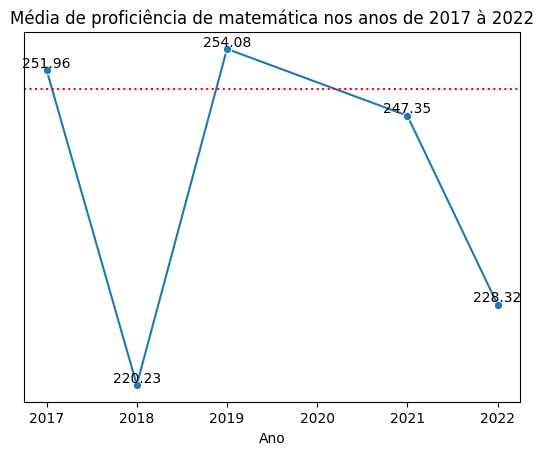

In [14]:
plt.title('Média de proficiência de matemática nos anos de 2017 à 2022')
ax = sns.lineplot(data=df_profic,x='Ano',y='Média Matemática',marker='o')
ax.set(yticks=[])
for line in ax.lines:
    x, y = line.get_xydata().T
    for xi, yi in zip(x, y):
        ax.text(xi, yi, f'{yi:.2f}', ha='center', va='bottom')
ax.axhline(y=250, color='red', ls=':')
plt.ylabel('')
plt.show()

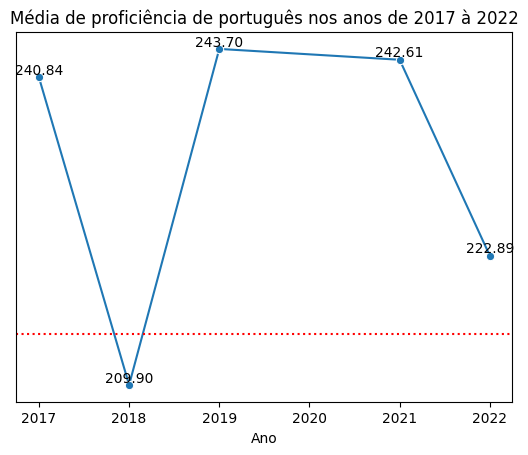

In [15]:
plt.title('Média de proficiência de português nos anos de 2017 à 2022')
ax = sns.lineplot(data=df_profic,x='Ano',y='Média Português',marker='o')
ax.set(yticks=[])
for line in ax.lines:
    x, y = line.get_xydata().T
    for xi, yi in zip(x, y):
        ax.text(xi, yi, f'{yi:.2f}', ha='center', va='bottom')
ax.axhline(y=215, color='red', ls=':')
plt.ylabel('')
plt.show()

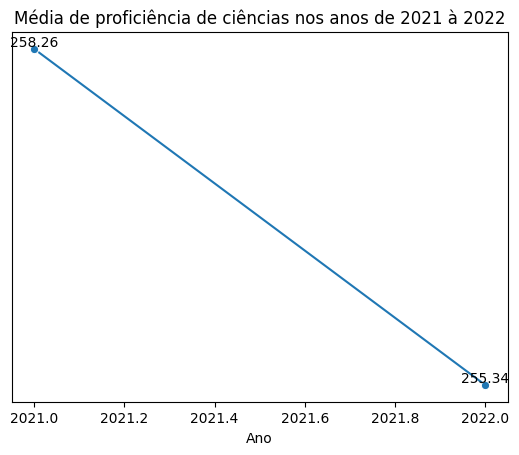

In [16]:
plt.title('Média de proficiência de ciências nos anos de 2021 à 2022')
ax = sns.lineplot(data=df_profic,x='Ano',y='Média Ciências',marker='o')
ax.set(yticks=[])
for line in ax.lines:
    x, y = line.get_xydata().T
    for xi, yi in zip(x, y):
        ax.text(xi, yi, f'{yi:.2f}', ha='center', va='bottom')
plt.ylabel('')
plt.show()

In [53]:
meanprops = {
    "marker":"o",
    "markerfacecolor":"black", 
    "markeredgecolor":"black",
    "markersize":"4"
}

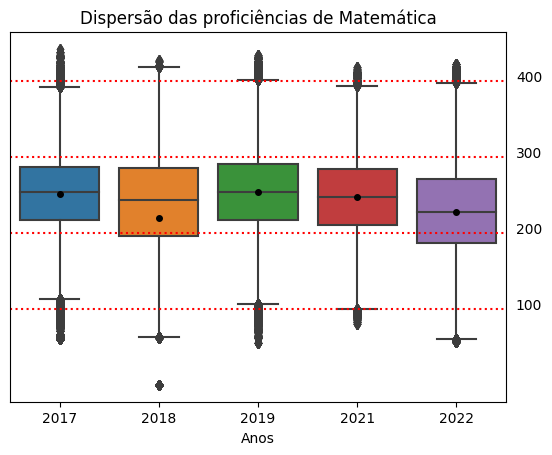

In [103]:
ax = sns.boxplot(data=df,x='ano_prova', y='profic_mat',showmeans=True,meanprops=meanprops)
plt.yticks([])
for y in [100,200,300,400]:
    ax.axhline(y=y, color='red', ls=':')
    ax.text(4.6,y,y)
plt.xlabel('Anos')
plt.ylabel('')
plt.title('Dispersão das proficiências de Matemática')
plt.savefig('/kaggle/working/boxplot-mat.png')

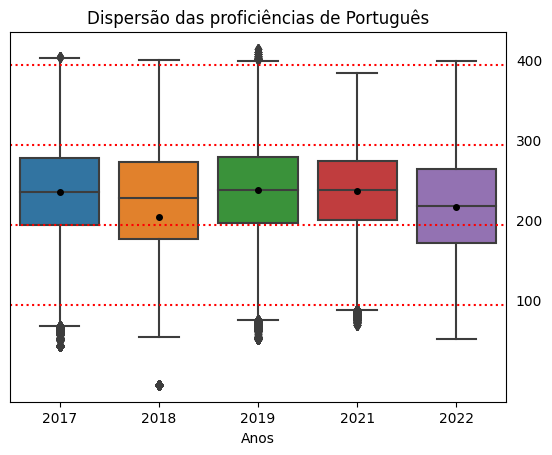

In [104]:
ax = sns.boxplot(data=df,x='ano_prova', y='profic_lp',showmeans=True,meanprops=meanprops)
plt.yticks([])
for y in [100,200,300,400]:
    ax.axhline(y=y, color='red', ls=':')
    ax.text(4.6,y,y)
plt.xlabel('Anos')
plt.ylabel('')
plt.title('Dispersão das proficiências de Português')
plt.savefig('/kaggle/working/boxplot-port.png')

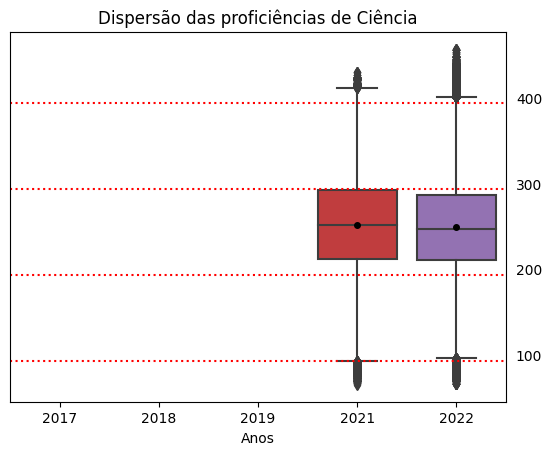

In [105]:
ax = sns.boxplot(data=df,x='ano_prova', y='profic_cie',showmeans=True,meanprops=meanprops)
plt.yticks([])
for y in [100,200,300,400]:
    ax.axhline(y=y, color='red', ls=':')
    ax.text(4.6,y,y)
plt.xlabel('Anos')
plt.ylabel('')
plt.title('Dispersão das proficiências de Ciência')
plt.savefig('/kaggle/working/boxplot-cie.png')

# Classificar municios/diretorias de ensino com base no desempenho dos alunos e identificar quais estão acima ou abaixo da média

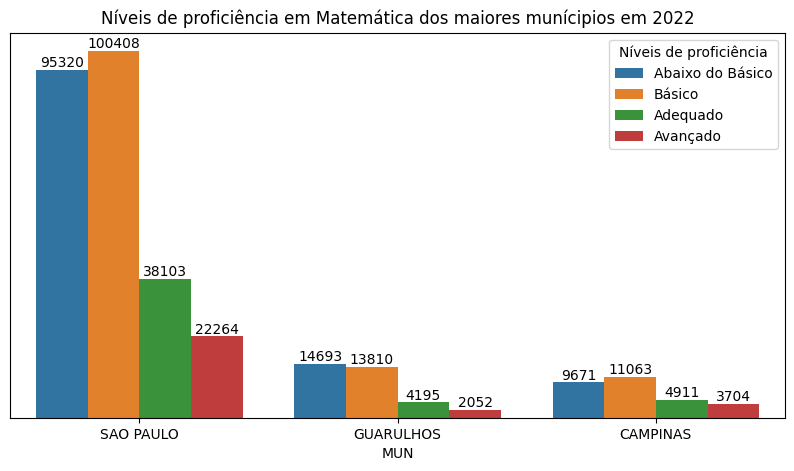

In [107]:
mun = df[(df['ano_prova'] == 2022) & (df['nivel_profic_mat'] == 'Abaixo do Básico')]['MUN'].value_counts()[0:3].index
plt.figure(figsize=(10,5))
plt.title('Níveis de proficiência em Matemática dos maiores munícipios em 2022')
ax = sns.countplot(data=df[(df['ano_prova'] == 2022) & (df['MUN'].isin(mun))], x='MUN',hue='nivel_profic_mat',hue_order=['Abaixo do Básico','Básico','Adequado','Avançado'])
plt.legend(title='Níveis de proficiência')
for container in ax.containers:
    ax.bar_label(container)
plt.ylabel('')
plt.yticks([])
plt.savefig('/kaggle/working/countplot-mat.png')

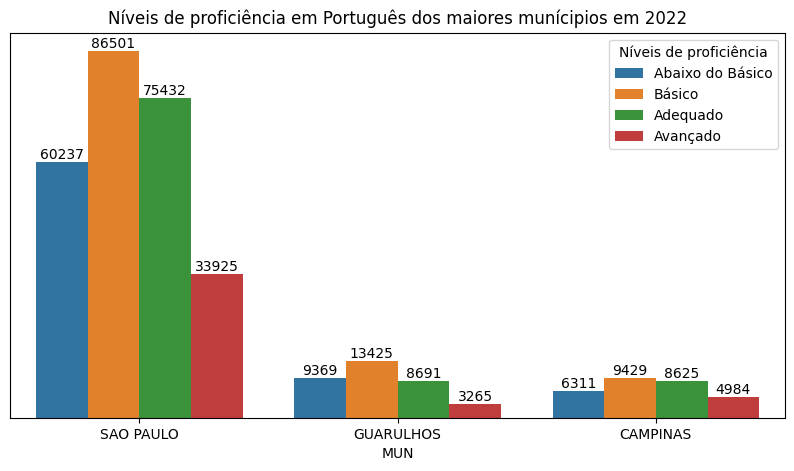

In [108]:
mun = df[(df['ano_prova'] == 2022) & (df['nivel_profic_lp'] == 'Abaixo do Básico')]['MUN'].value_counts()[0:3].index
plt.figure(figsize=(10,5))
plt.title('Níveis de proficiência em Português dos maiores munícipios em 2022')
ax = sns.countplot(data=df[(df['ano_prova'] == 2022) & (df['MUN'].isin(mun))], x='MUN',hue='nivel_profic_lp',hue_order=['Abaixo do Básico','Básico','Adequado','Avançado'])
plt.legend(title='Níveis de proficiência')
for container in ax.containers:
    ax.bar_label(container)
plt.ylabel('')
plt.yticks([])
plt.savefig('/kaggle/working/countplot-port.png')

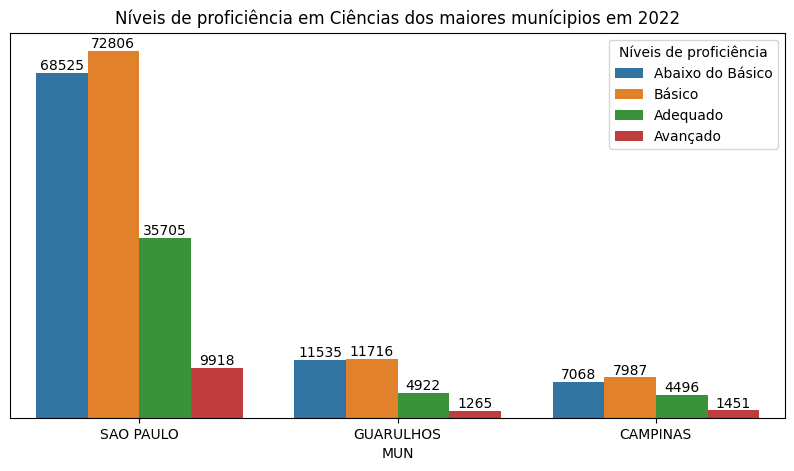

In [109]:
mun = df[(df['ano_prova'] == 2022) & (df['nivel_profic_cie'] == 'Abaixo do Básico')]['MUN'].value_counts()[0:3].index
plt.figure(figsize=(10,5))
plt.title('Níveis de proficiência em Ciências dos maiores munícipios em 2022')
ax = sns.countplot(data=df[(df['ano_prova'] == 2022) & (df['MUN'].isin(mun))], x='MUN',hue='nivel_profic_cie',hue_order=['Abaixo do Básico','Básico','Adequado','Avançado'])
plt.legend(title='Níveis de proficiência')
for container in ax.containers:
    ax.bar_label(container)
plt.ylabel('')
plt.yticks([])
plt.savefig('/kaggle/working/countplot-cie.png')

# Investigar se existe uma diferença significativa de desempenho entre alunos do sexo masculino e feminino ou de periodos distintos.

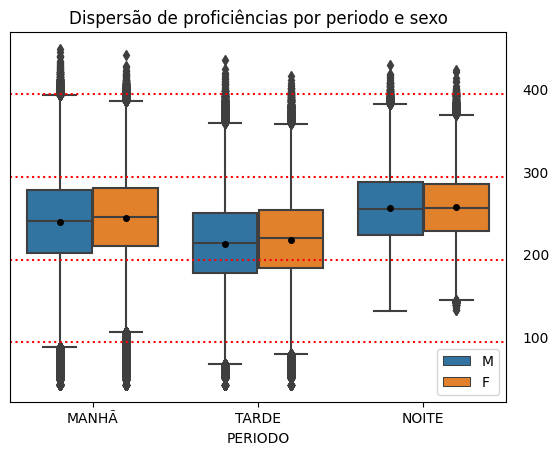

In [111]:
ax = sns.boxplot(data=df,y='MEDIA_PROFIC',x='PERIODO',hue='SEXO',order=['MANHÃ','TARDE','NOITE'],showmeans=True,meanprops=meanprops)
plt.title('Dispersão de proficiências por periodo e sexo')
plt.yticks([])
for y in [100,200,300,400]:
    ax.axhline(y=y, color='red', ls=':')
    ax.text(2.6,y,y)
plt.legend(loc="lower right")
plt.ylabel('')
plt.savefig('/kaggle/working/boxplot-sexo-periodo.png')